In [6]:
from rdkit import RDConfig
#RDConfig.RDDataDir =  'C:/Users/timur/anaconda3/envs/Cheminformatics_env/Lib/site-packages/rdkit/Data'
from tqdm import tqdm
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from sklearn.decomposition import PCA
import datamol as dm
from molfeat.calc import RDKitDescriptors2D, RDKitDescriptors3D
from molfeat.trans import MoleculeTransformer
from molfeat_padel.calc import PadelDescriptors
import pickle
from sklearn.impute import KNNImputer
from feature_engine.selection import DropCorrelatedFeatures 
from rdkit.Chem.rdMolAlign import AlignMol

In [7]:
Data = pd.read_excel('Data.xlsx', sheet_name='Sheet1')

In [8]:
Data.head()

,Trivial name,SMILES,CTAB concentration (mM),Additive concentration,CTAB/additive,Temperature,Is gel,Zero-shear viscosity
0,4-[(E)-phenyldiazenyl] benzoate,[O-]C(=O)c1ccc(/N=N/c2ccccc2)cc1,20.0,3.245562,6.162262,50.0,0,1.044777
1,4-[(E)-phenyldiazenyl] benzoate,[O-]C(=O)c1ccc(/N=N/c2ccccc2)cc1,20.0,7.526631,2.657232,50.0,0,1.947203
2,4-[(E)-phenyldiazenyl] benzoate,[O-]C(=O)c1ccc(/N=N/c2ccccc2)cc1,20.0,8.556309,2.337456,50.0,0,3.707292
3,4-[(E)-phenyldiazenyl] benzoate,[O-]C(=O)c1ccc(/N=N/c2ccccc2)cc1,20.0,9.569015,2.090079,50.0,1,68.649643
4,4-[(E)-phenyldiazenyl] benzoate,[O-]C(=O)c1ccc(/N=N/c2ccccc2)cc1,20.0,10.568348,1.892443,50.0,1,7631.210212


In [9]:
def canonicalize_smiles(smi):
    try:
        new_smi =  Chem.MolToSmiles(Chem.MolFromSmiles(smi))
        return new_smi
    except:
        print(smi)

In [10]:
Data.loc[:, 'SMILES']  = Data['SMILES'].apply(canonicalize_smiles)

In [11]:
fingerprints = []
for i, smi in enumerate(Data.SMILES.values):
    fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius = 3))
fingerprints = np.array(fingerprints)

In [12]:
fp_df = pd.DataFrame(np.stack(fingerprints), columns = ['fp{}'.format(i) for i in range(2048)])

In [13]:
X = pd.concat([Data.drop(columns = ['Trivial name', 'SMILES', 'Is gel', 'Zero-shear viscosity']), fp_df], axis = 1)

In [14]:
pca = PCA(n_components=2, svd_solver='full')
principal_components = pca.fit_transform(X)

<Axes: >

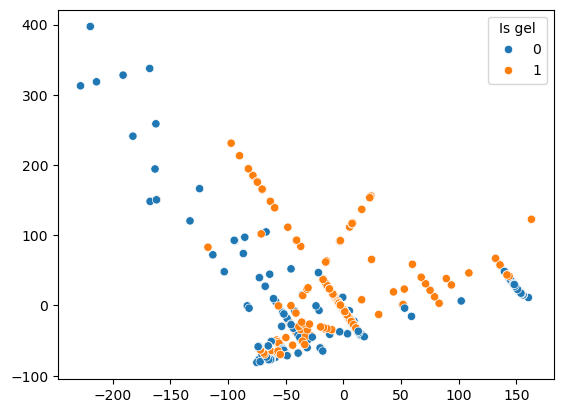

In [15]:
sns.scatterplot(x = principal_components[:,0], y = principal_components[:,1], hue = Data['Is gel'])

In [16]:
def embed_optimize(smi):
    m = Chem.MolFromSmiles(smi)
    m = Chem.AddHs(m)
    AllChem.EmbedMolecule(m)
    AllChem.MMFFOptimizeMolecule(m, maxIters=500)
    return m

In [17]:
Data['mol'] = Data.SMILES.apply(embed_optimize)

In [18]:
calc_2d = RDKitDescriptors2D()
calc_3d = RDKitDescriptors3D()
trans_2D = MoleculeTransformer(calc_2d, verbose = True)
trans_3D = MoleculeTransformer(calc_3d, verbose = True)

In [19]:
with dm.without_rdkit_log():
    feats_2D = trans_2D(Data.mol.values)
    feats_3D = trans_3D(Data.mol.values)

C:\Users\Timur\anaconda3\envs\Cheminformatics_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Standard descriptors set will contain Morgan fingerprints and RDKit descriptors (2D and 3D)**

In [52]:
_descriptors = pd.DataFrame(np.concatenate([feats_2D, feats_3D], axis  = 1), columns=calc_2d.columns + calc_3d.columns)
X_standard = pd.concat([X, _descriptors], axis = 1)
X_standard = X_standard.dropna(axis =1, how = 'all')
X_standard.drop(columns='Alerts', inplace = True)

**Padel descriptors**

In [106]:
compounds_smi = Data.SMILES.unique()

In [109]:
calc_padel = MoleculeTransformer(featurizer=PadelDescriptors())

In [115]:
padel_dict = {}
for smi in tqdm(compounds_smi):
    padel_dict[smi]= calc_padel(smi)

100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [05:59<00:00,  3.02s/it]


In [150]:
X_padel['padel'] = pd.Series([padel_dict[smi].flatten() for smi in X_padel.SMILES.values])

In [159]:
_descriptors_padel = pd.DataFrame(np.stack(X_padel['padel'].to_numpy()), columns=PadelDescriptors().columns)

In [164]:
X_padel = pd.concat([X_padel.drop(columns = ['padel', 'Trivial name', 'SMILES', 'Is gel', 'Zero-shear viscosity', 'mol']), _descriptors_padel], axis = 1)

**Start here**

In [15]:
columns = X_padel.columns

In [16]:
imputer = KNNImputer()
X_padel = imputer.fit_transform(X_padel)
X_padel = pd.DataFrame(X_padel, columns=columns)

In [23]:
with open('X_padel.pickle', 'rb') as input:
    X_padel = pickle.load(input)

In [24]:
with open('X_standard.pickle', 'rb') as input:
    X_standard = pickle.load(input)

In [54]:
dropper = DropCorrelatedFeatures(threshold=0.8)
X_standard_dropped = dropper.fit_transform(X_standard)

In [40]:
padel_dropped = DropCorrelatedFeatures(threshold=0.8)
X_padel_dropped = dropper.fit_transform(X_padel)

In [41]:
with open('X_standard_dropped.pickle', 'wb') as output:
    pickle.dump(X_standard_dropped, output)

In [43]:
with open('X_padel_dropped.pickle', 'wb') as output:
    pickle.dump(X_padel_dropped, output)

In [42]:
with open('features_to_drop.pickle', 'wb') as output:
    pickle.dump(dropper.features_to_drop_, output)

**PCA decomposition**

In [60]:
pca = PCA(n_components=  605)
X_standard_pca = pca.fit_transform(X_standard)

In [61]:
pca = PCA(n_components=  605)
X_padel_pca = pca.fit_transform(X_padel)

In [64]:
X_padel_pca = pd.DataFrame(X_padel_pca, columns = ['PCA {}'.format(i) for i in range(X_padel_pca.shape[1])])

In [66]:
X_standard_pca = pd.DataFrame(X_standard_pca, columns = ['PCA {}'.format(i) for i in range(X_standard_pca.shape[1])])

In [68]:
with open('X_standard_pca.pickle', 'wb') as output:
    pickle.dump(X_standard_pca, output)

In [69]:
with open('X_padel_pca.pickle', 'wb') as output:
    pickle.dump(X_padel_pca, output)

In [3]:
y = Data['Is gel']

In [6]:
with open('y.pickle', 'wb') as output:
    pickle.dump(y, output)


**Grouping with SMILES for better cross-validation**

In [16]:
groups_dict = {smi: i for i, smi in enumerate(Data['SMILES'].unique())}

In [18]:
Data['group'] = pd.Series([groups_dict[smi] for smi in Data['SMILES'].values])

In [20]:
with open('groups.pickle', 'wb') as output:
    pickle.dump(Data['group'].values, output)

In [65]:
viscosity = Data['Zero-shear viscosity']

In [66]:
with open('viscosity.pickle', 'wb') as output:
    pickle.dump(viscosity, output)